# Early stopping in polynomial regression

I was running the [example from scikit-learn site](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), that demonstrated the underfitting and overfitting. Below is a modified version of this code.

Degree:  1  Coefficients:  [-1.60931179]
Degree:  4  Coefficients:  [  0.46754142 -17.78954475  23.5926603   -7.26289872]
Degree:  15  Coefficients:  [-2.98294669e+03  1.03899932e+05 -1.87417069e+06  2.03717225e+07
 -1.44873987e+08  7.09318780e+08 -2.47066977e+09  6.24564048e+09
 -1.15677067e+10  1.56895696e+10 -1.54006776e+10  1.06457788e+10
 -4.91379977e+09  1.35920330e+09 -1.70381654e+08]


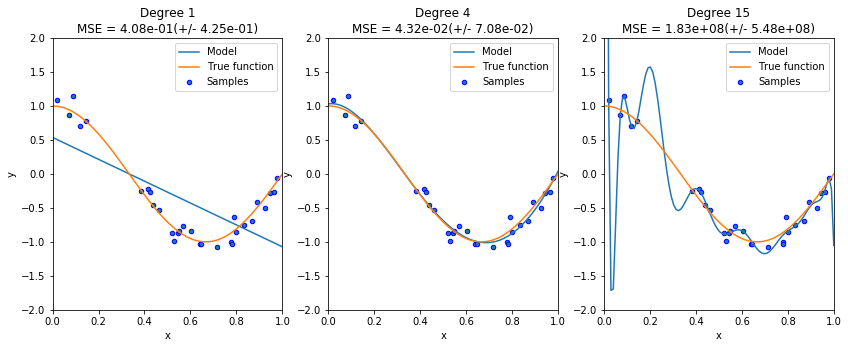

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    print("Degree: ", degrees[i], " Coefficients: ", pipeline.steps[1][1].coef_)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

This code was meant to demonstrate, that the model underfits if we pick a polynomial model of degree 1 (that is, a linear function), will fit well for a polynomial model of degree 4 and will overfit for a polynomial model of degree 15. You can clearly see it on the chart on the right side. The curve, predicted by the model is not smooth, and, although it fits training data very well, it does not fit the test data. If you look at the coefficients, you can see they are very large, which also indicates that the model is overfitting.

What I found strange, that when I reimplemented the algorithm in TensorFlow, I did not get overfitting for degree 15, but the curve was almost identical to the curve for Degree 4 polynomial. Then I thought it actually makes sense. The way scikit-learn works is that if I don't specify the solver explicitly, for small datasets the system will not use iterative algorithms, but instead choose a closed form solution:

$$ \beta = (X^TX)^{-1}X^Ty $$

or similar closed form solutions. Hence, it will choose the best-fitting solution, even though the coefficients may be extreme, model non-smooth, and poor test set performance. 

However, if I am using Gradient Descent or a similar optimization algorithm, I set the initial coefficients to zero, and during training they will not have enough time to grow sufficiently large before the required precision is achieved. You can see this in the modified example below, where I changed the solver to `lsqr`, consider only degree 15 model, and iterate over different values of precision:

Precision:  0.001  Coefficients:  [-1.39643577 -6.11889248  0.28314865  3.86307571  4.14759799  2.67764034
  0.72228739 -0.97903546 -2.08818249 -2.51091926 -2.28201919 -1.4942374
 -0.25855014  1.31619122  3.13246963]
Iterations:  [5]
Precision:  1e-05  Coefficients:  [-1.93501535 -3.88730173 -1.9530687   2.53485144  4.69825473  4.11597739
  2.03932122 -0.33779526 -2.27218909 -3.39309999 -3.55644046 -2.73960954
 -0.98212465  1.64432236  5.05061194]
Iterations:  [8]
Precision:  1e-07  Coefficients:  [    3.3793661    -85.44850536   486.98966891 -1252.45510959
  1066.77967223   661.60279476  -716.29325314  -938.97967844
   -80.15991922   781.02879244   852.50582781   108.82090525
  -809.84249688  -913.13924961   834.71764111]
Iterations:  [20]
Precision:  1e-11  Coefficients:  [-5.31511710e+01  1.20818460e+03 -1.26725939e+04  6.79389251e+04
 -1.98651349e+05  3.02119011e+05 -1.53189889e+05 -1.57101976e+05
  1.60948956e+05  1.20392494e+05 -1.32735137e+05 -9.65907000e+04
  1.28854048e+05 -2.

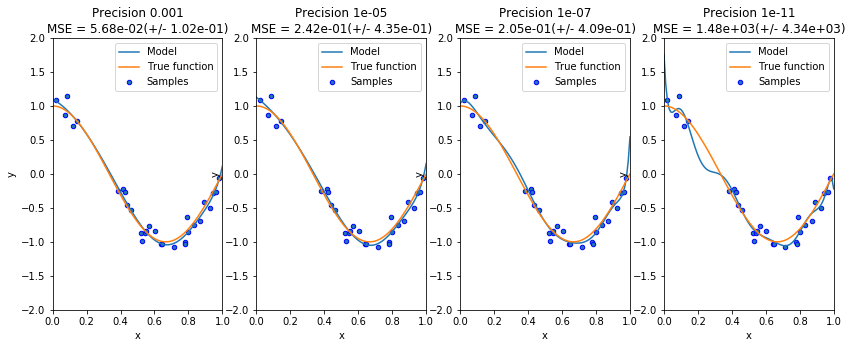

In [28]:
np.random.seed(0)

n_samples = 30
degree = 15
precisions = [1E-3, 1E-5, 1E-7, 1E-11]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i, precision in enumerate(precisions):
    ax = plt.subplot(1, len(precisions), i + 1)

    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = Ridge(alpha=0, solver='lsqr', tol=precision, max_iter=10000)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    print("Precision: ", precision, " Coefficients: ", pipeline.steps[1][1].coef_)
    print('Iterations: ', pipeline.steps[1][1].n_iter_)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Precision {}\nMSE = {:.2e}(+/- {:.2e})".format(
        precision, -scores.mean(), scores.std()))
plt.show()

From this you can see, that for the default precision of 0.001, the model makes only 5 iterations before achieving the desired accuracy. Also all coefficients are in the reasonable range, and the model produces the curve almost identical to the true function. The model does not have a chance to overfit. As we increasing our precision requirements, we can see that the number of iterations is going up, and the model starts to overfit. Still it does not overfit so badly, as in the case of closed-form solution. 

This phenomenon is well known, and it inspired [early stopping](https://en.wikipedia.org/wiki/Early_stopping) techiques, that is used to regularize neural networks since 1990s. The technique is very simple: you abort training when you see that the performance on the validation set started to deteriorate.  And, while at times it is difficult to find theoretical justification of this technique for deep neural networks, this simple example shows its effectiveness on a very simple polynomial regression algorithm.

## Conclusion

Early stopping is a well known regularization technique for deep learning. Here we demonstrated its usefulness for a simple case of Polynomial Regression.
